In [534]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

from scipy import stats


In [535]:
distances_df = pd.read_csv('C:/Users/Ryan Fu/Desktop/health supply/distances.csv')
demand_df= pd.read_csv('C:/Users/Ryan Fu/Desktop/health supply/demands.csv')
centers_df = pd.read_csv('C:/Users/Ryan Fu/Desktop/health supply/centers.csv')

In [536]:
demand_df.head()

,Year,Region,Demand
0,2013,Downtown Toronto,249581
1,2013,East York,172730
2,2013,Etobicoke,285764
3,2013,Mississauga East,255427
4,2013,North Toronto,263276


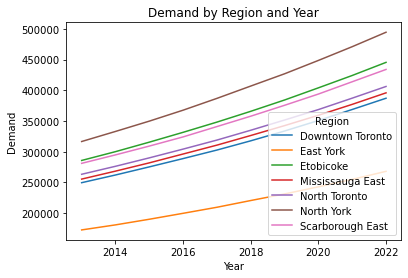

In [537]:
pivot_df = demand_df.pivot(index='Year', columns='Region', values='Demand')
pivot_df.plot(kind='line')
plt.title('Demand by Region and Year')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.show()

# Linear regression predict future demand

In [538]:
from sklearn.linear_model import LinearRegression

# different region with different linear model
models = {}
regions = []
for region in pivot_df.columns:
    model = LinearRegression()
    X_train = pivot_df.index.values.reshape(-1, 1)
    y_train = pivot_df[region].values
    model.fit(X_train, y_train)
    models[region] = model
    regions.append(region)

years = [2023,2024,2025]
result_list = []
for r in regions:
    for y in years:
        X = pd.DataFrame([y])
        y_pred = models[r].predict(X)[0]
        result_list.append([y,r,y_pred])

In [539]:
predicted = pd.DataFrame(result_list, columns=['Year', 'Region', 'Demand'])
predicted

,Year,Region,Demand
0,2023,Downtown Toronto,397295.666667
1,2024,Downtown Toronto,412506.860606
2,2025,Downtown Toronto,427718.054545
3,2023,East York,275250.800000
4,2024,East York,285828.200000
5,2025,East York,296405.600000
6,2023,Etobicoke,457808.066667
7,2024,Etobicoke,475512.987879
8,2025,Etobicoke,493217.909091
9,2023,Mississauga East,406851.400000


In [540]:
combined_df = pd.concat([demand_df, predicted])

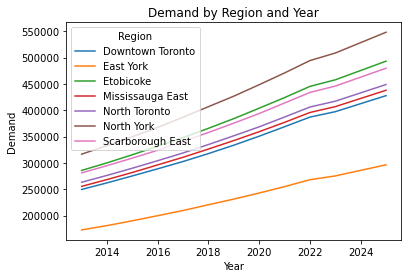

In [541]:
pivot_df = combined_df.pivot(index='Year', columns='Region', values='Demand')
pivot_df.plot(kind='line')
plt.title('Demand by Region and Year')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.show()

# Basic model

In [542]:
#Center
centers = list(centers_df['Center'])
numcenters = len(centers)

#Region
numregion = len(regions)

In [543]:
one_year_df = predicted[predicted['Year'] == 2023]
one_year_df

,Year,Region,Demand
0,2023,Downtown Toronto,397295.666667
3,2023,East York,275250.800000
6,2023,Etobicoke,457808.066667
9,2023,Mississauga East,406851.400000
12,2023,North Toronto,417190.200000
15,2023,North York,508686.466667
18,2023,Scarborough East,445900.800000


In [544]:

region_demand = {}
for i in regions:
    region_demand[i] = int(one_year_df[one_year_df["Region"] == i]["Demand"])

#center operating cost
center_operating_cost ={}
for i in centers:
    center_operating_cost[i]= int(centers_df[centers_df["Center"] == i]["Operating Costs"])
    
    
#center opening cost
center_opening_cost = {}
for i in centers:
    center_opening_cost[i]= int(centers_df[centers_df["Center"] == i]["Opening Costs"])

#center MPs
center_mp = {}
for i in centers:
    center_mp[i]= int(centers_df[centers_df["Center"] == i]["Num MPs"])

#center_capacity
center_capacity ={}
for i in centers:
    center_capacity[i]= int(centers_df[centers_df["Center"] == i]["Maximum capacity"])
    
#center_region_distance
center_region_distance = {}
for i in centers:
    for j in regions:
        center_region_distance[(i,j)]=float(distances_df[(distances_df["Center"]==i)&(distances_df["Region"]==j)]["Distance"])

Variables

In [545]:
# Variables: if a center is opened/allocated
yvar = pulp.LpVariable.dict("y", centers, cat=pulp.LpBinary)

# Variables: amount of demand from center to region
xvar = pulp.LpVariable.dict("x", (centers, regions), lowBound=0.0, cat=pulp.LpContinuous)

In [546]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

Constrain

In [547]:
# Contraint: supply must less than/equal to the demand
for j in regions:
    locationModel += pulp.lpSum( [xvar[(i,j)] for i in centers] ) <= region_demand[j]

# Contraint: supply must less than/equal to the center capacity 
for i in centers:
    locationModel += pulp.lpSum( [xvar[(i,j)] for j in regions] ) <= center_capacity[i] * yvar[i]

# MP must under their service hours     
hours = 6
days = 250
for i in centers:
    locationModel += pulp.lpSum( [xvar[(i,j)] for j in regions] ) <= center_mp[i] * hours * days * yvar[i]

Objective function

In [548]:
# Objective function

# --- reimbursment from government
obj = pulp.lpSum( [ 42 * xvar[(i,j)] for i in centers for j in regions ])
# --- center operating costs
obj -=  pulp.lpSum([ center_operating_cost[i] * yvar[i] for i in centers])
# --- center opening costs
obj -= pulp.lpSum([ center_opening_cost[i] * yvar[i] for i in centers])
# --- MP cost
obj -= pulp.lpSum( [ ((center_region_distance[(i,j)] * 0.25) + 37.85)  * xvar[(i,j)] for i in centers for j in regions ] )


# add objective to model
locationModel += obj

Solution

In [549]:
# Write LP to file (optional, but often good to inspect model and find errors)
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [550]:
# Total cost
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: 2028499.999999999


In [551]:
# Print solution (you can add to the dataframe if needed)
for i in centers:
    if yvar[i].varValue >= 1.0:
        print("Center " + str(i) + " is opened")                            
        for j in regions:
            if xvar[(i,j)].varValue > 0.0:
                print("\t\tServes region " + str(j) + " - with capacity " + str(xvar[(i,j)].varValue))

Center Center A is opened
		Serves region North York - with capacity 322500.0
Center Center B is opened
		Serves region Scarborough East - with capacity 187500.0
Center Center D is opened
		Serves region Mississauga East - with capacity 180000.0


# Model adding year variation

In [552]:
year_region_demand = {}
for i in years:
    for j in regions:
        year_region_demand[(i,j)] = int(predicted[(predicted["Year"] == i)&(predicted["Region"] == j)]["Demand"])

#center operating cost
center_operating_cost ={}
for i in centers:
    center_operating_cost[i]= int(centers_df[centers_df["Center"] == i]["Operating Costs"])
    
    
#center opening cost
center_opening_cost = {}
for i in centers:
    center_opening_cost[i]= int(centers_df[centers_df["Center"] == i]["Opening Costs"])

#center MPs
center_mp = {}
for i in centers:
    center_mp[i]= int(centers_df[centers_df["Center"] == i]["Num MPs"])

#center_capacity
center_capacity ={}
for i in centers:
    center_capacity[i]= int(centers_df[centers_df["Center"] == i]["Maximum capacity"])
    
#center_region_distance
center_region_distance = {}
for i in centers:
    for j in regions:
        center_region_distance[(i,j)]=float(distances_df[(distances_df["Center"]==i)&(distances_df["Region"]==j)]["Distance"])

In [553]:
# Variables: if a center is operating/allocated
yvar = pulp.LpVariable.dict("y", (years, centers), cat=pulp.LpBinary)

# Variables: amount of demand from center to region
xvar = pulp.LpVariable.dict("x", (years, centers, regions), lowBound=0.0, cat=pulp.LpContinuous)

In [554]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

In [555]:
for i in years:
    for j in regions:
        locationModel += pulp.lpSum( [xvar[(i,k,j)] for k in centers] ) <= year_region_demand[(i,j)]

# Contraint: supply must less than/equal to the center capacity 
for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= center_capacity[j] * yvar[(i,j)]

        
        
# MP must under their service hours     
hours = 6
days = 250
for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= center_mp[j]  * hours * days

In [556]:
# Objective function
new_centers = [ 'Center E', 'Center F']
later_years = [2024,2025]
# --- reimbursment from government
obj = pulp.lpSum( [ 42 * xvar[(i,j,k)] for i in years for j in centers for k in regions ])

# --- center operating costs
obj -=  pulp.lpSum([ center_operating_cost[j] * yvar[(i,j)] for i in years for j in centers])
# --- center opening costs   *****not open twice
obj -= pulp.lpSum([ center_opening_cost[j] * yvar[(i,j)] for i in years for j in centers])
# # --- center opening costs compensation
# obj += pulp.lpSum([ center_opening_cost[j] * yvar[(i-1,j)] for i in later_years for j in new_centers])
# --- MP cost
obj -= pulp.lpSum( [  ((center_region_distance[(j,k)] * 0.25) + ((1.025**(i-2023)) * 37.85))  * xvar[(i,j,k)] for i in years for j in centers for k in regions ] )

# add objective to model
locationModel += obj

In [557]:
# Write LP to file (optional, but often good to inspect model and find errors)
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [558]:
# Total cost
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: 4110439.687499998


In [559]:
# Print solution (you can add to the dataframe if needed)
for i in years:
    for j in centers:
        if yvar[i,j].varValue >= 1.0:
            print("Center " + str(j) + " is opened" + str(i)) 
            for k in regions:
                if xvar[(i,j,k)].varValue > 0.0:
                    print("\t\tServes region " + str(k) + " - with capacity " + str(xvar[(i,j,k)].varValue))

Center Center A is opened2023
		Serves region North York - with capacity 322500.0
Center Center B is opened2023
		Serves region Scarborough East - with capacity 187500.0
Center Center D is opened2023
		Serves region Mississauga East - with capacity 180000.0
Center Center A is opened2024
		Serves region North York - with capacity 322500.0
Center Center B is opened2024
		Serves region Scarborough East - with capacity 187500.0
Center Center D is opened2024
		Serves region Mississauga East - with capacity 180000.0
Center Center A is opened2025
		Serves region North York - with capacity 322500.0
Center Center B is opened2025
		Serves region Scarborough East - with capacity 187500.0
Center Center D is opened2025
		Serves region Mississauga East - with capacity 180000.0


# Complete model 

In [560]:
#Center
centers = list(centers_df['Center'])
numcenters = len(centers)

#Region

numregion = len(regions)


# Data dict

In [561]:
#demand in each region dict
year_region_demand = {}
for i in years:
    for j in regions:
        year_region_demand[(i,j)] = int(predicted[(predicted["Year"] == i)&(predicted["Region"] == j)]["Demand"])

# combine opening and operating Costs, assuming that centers can be opened only in the first year         
center_operating_cost ={}
for j in years:
    for i in centers:
        center_operating_cost[(j,i)]= int(centers_df[centers_df["Center"] == i]["Operating Costs"])
## add opening cost to first year for new centers
new_centers = [ 'Center E', 'Center F']
for c in new_centers:
    center_operating_cost[(2023,c)] = int(centers_df[centers_df["Center"] == c]["Operating Costs"])+int(centers_df[centers_df["Center"] == c]["Opening Costs"])

#center MPs
center_mp = {}
for i in centers:
    center_mp[i]= int(centers_df[centers_df["Center"] == i]["Num MPs"])

#center_capacity
center_capacity ={}
for i in centers:
    center_capacity[i]= int(centers_df[centers_df["Center"] == i]["Maximum capacity"])
    
#center_region_distance
center_region_distance = {}
for i in centers:
    for j in regions:
        center_region_distance[(i,j)]=float(distances_df[(distances_df["Center"]==i)&(distances_df["Region"]==j)]["Distance"])
        

# Variables

In [562]:

# Variables: if a center is operating/allocated
yvar = pulp.LpVariable.dict("y", (years, centers), cat=pulp.LpBinary)

# Variables: amount of demand from center to region
xvar = pulp.LpVariable.dict("x", (years, centers, regions), lowBound=0.0, cat=pulp.LpContinuous)

# Variables: amount of worker in each center every year
wvar = pulp.LpVariable.dict("w", (years, centers), lowBound=0.0, cat=pulp.LpInteger)

# Variables: amount of new hiring in each center every year
hvar = pulp.LpVariable.dict("h", (years, centers), lowBound=0.0, cat=pulp.LpInteger)


In [563]:
# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

Constrain

In [564]:
# Contraint: supply must less than/equal to the demand
for i in years:
    for j in regions:
        locationModel += pulp.lpSum( [xvar[(i,k,j)] for k in centers] ) == year_region_demand[(i,j)]
        
# # Contraint: if supply must equal to the demand
# for i in years:
#     for j in regions:
#         locationModel += pulp.lpSum( [xvar[(i,k,j)] for k in centers] ) == year_region_demand[(i,j)]

# Contraint: supply must less than/equal to the center capacity 
for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= center_capacity[j] * yvar[(i,j)]


# Contraint: time period
#MP per centers in each year
for t in years:
    for c in centers:
        #update number of worker
        num_MP_in_center = (wvar[(t-1,c)] if t !=2023 else center_mp[c])+hvar[(t,c)]
        locationModel += (wvar[(t,c)] == num_MP_in_center)
        #new MP less than 300 per center per year
        locationModel += (hvar[(t,c)] <= 300)
        #new
        
##constraint: open before operating
for c in new_centers:
    locationModel += (yvar[(2023,c)] >= yvar[(2024,c)])
    locationModel += (yvar[(2023,c)] >= yvar[(2025,c)])
        
#Contraint: MP must under their service hours     
hours = 6
days = 250

for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= wvar[(i,j)] * hours * days


Objective function

In [565]:
# Objective function

# --- reimbursment from government
obj = pulp.lpSum( [ 42 * xvar[(i,j,k)] for i in years for j in centers for k in regions ])

# --- center operating costs
obj -=  pulp.lpSum([ center_operating_cost[(i,j)] * yvar[(i,j)] for i in years for j in centers])
# # --- center opening costs   
# obj -= pulp.lpSum([ center_opening_cost[j] * yvar[(i,j)] for i in years for j in centers])

# --- MP cost
obj -= pulp.lpSum( [  ((center_region_distance[(j,k)] * 0.25) + ((1.025**(i-2023)) * 37.85))  * xvar[(i,j,k)] for i in years for j in centers for k in regions ] )

#hiring new MP cost
obj -= pulp.lpSum(15000 * hvar[(i,j)] for i in years for j in centers)

# add objective to model
locationModel += obj

# Solution

In [566]:
# Write LP to file (optional, but often good to inspect model and find errors)
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])

Status: Optimal


In [567]:
# Total cost
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit))

Total profit: -13203783.855437512


In [568]:
# Print solution (you can add to the dataframe if needed)
cap_list = []
worker_list = []
service_list = []
for i in years:
    for j in centers:
        if yvar[i,j].varValue >= 1.0:
            working_cap = wvar[i,j].varValue *hours*days
            print("Center " + str(j) + " is opened" + str(i)) 
            print("worker:" + str(wvar[i,j].varValue) + "  new people:" + str(hvar[i,j].varValue))
            print(" avaliable working capacity:" +str(working_cap))
            worker_list.append([i,j,wvar[i,j].varValue,hvar[i,j].varValue])
            sum_cap = 0      
            for k in regions:
                if xvar[(i,j,k)].varValue > 0.0:
                    print("\t\tServes region " + str(k) + " - with capacity " + str(xvar[(i,j,k)].varValue))
                    service_list.append([i,j,k,xvar[(i,j,k)].varValue])
                    sum_cap += xvar[(i,j,k)].varValue
            full_cap = str(sum_cap == working_cap)
            cap_diff = str(working_cap - sum_cap)
            print("full capacity:" + full_cap)
            print(str(sum_cap))
            cap_list.append([i,j,full_cap,cap_diff])

Center Center A is opened2023
worker:515.0  new people:300.0
 avaliable working capacity:772500.0
		Serves region East York - with capacity 263814.0
		Serves region North York - with capacity 508686.0
full capacity:True
772500.0
Center Center B is opened2023
worker:320.0  new people:195.0
 avaliable working capacity:480000.0
		Serves region East York - with capacity 11436.0
		Serves region Etobicoke - with capacity 21644.0
		Serves region Scarborough East - with capacity 445900.0
full capacity:False
478980.0
Center Center C is opened2023
worker:234.0  new people:134.0
 avaliable working capacity:351000.0
		Serves region Downtown Toronto - with capacity 351000.0
full capacity:True
351000.0
Center Center D is opened2023
worker:271.0  new people:151.0
 avaliable working capacity:406500.0
		Serves region Mississauga East - with capacity 406500.0
full capacity:True
406500.0
Center Center E is opened2023
worker:300.0  new people:300.0
 avaliable working capacity:450000.0
		Serves region Down

In [569]:
cap_df= pd.DataFrame(cap_list, columns=['Year', 'Center', 'Full',"cap_difference"])
cap_df

,Year,Center,Full,cap_difference
0,2023,Center A,True,0.0
1,2023,Center B,False,1020.0
2,2023,Center C,True,0.0
3,2023,Center D,True,0.0
4,2023,Center E,True,0.0
5,2023,Center F,True,0.0
6,2024,Center A,True,0.0
7,2024,Center B,False,17115.0
8,2024,Center C,False,95805.0
9,2024,Center D,True,0.0


In [570]:
service_list
ser_df= pd.DataFrame(service_list, columns=['Year', 'Center', 'Region',"Capacity"])
ser_df

,Year,Center,Region,Capacity
0,2023,Center A,East York,263814.0
1,2023,Center A,North York,508686.0
2,2023,Center B,East York,11436.0
3,2023,Center B,Etobicoke,21644.0
4,2023,Center B,Scarborough East,445900.0
5,2023,Center C,Downtown Toronto,351000.0
6,2023,Center D,Mississauga East,406500.0
7,2023,Center E,Downtown Toronto,32810.0
8,2023,Center E,North Toronto,417190.0
9,2023,Center F,Downtown Toronto,13485.0


In [571]:

worker_list
work_df= pd.DataFrame(worker_list, columns=['Year', 'Center', 'Worker',"New_worker"])
work_df

,Year,Center,Worker,New_worker
0,2023,Center A,515.0,300.0
1,2023,Center B,320.0,195.0
2,2023,Center C,234.0,134.0
3,2023,Center D,271.0,151.0
4,2023,Center E,300.0,300.0
5,2023,Center F,300.0,300.0
6,2024,Center A,543.0,28.0
7,2024,Center B,320.0,0.0
8,2024,Center C,234.0,0.0
9,2024,Center D,271.0,0.0


In [572]:
work_df.sum()

Year                                                      36432
Center        Center ACenter BCenter CCenter DCenter ECenter...
Worker                                                   6118.0
New_worker                                               1529.0
dtype: object

In [573]:
690000/ 3132184.890909

0.22029350885469384

In [574]:
first_y = predicted[predicted['Year'] == 2023]
first_y.sum()

Year                                                  14161
Region    Downtown TorontoEast YorkEtobicokeMississauga ...
Demand                                            2908983.4
dtype: object

In [575]:
second_y = predicted[predicted['Year'] == 2024]
second_y .sum()

Year                                                  14168
Region    Downtown TorontoEast YorkEtobicokeMississauga ...
Demand                                       3020584.145455
dtype: object

In [576]:
third_y = predicted[predicted['Year'] == 2025]
third_y .sum()

Year                                                  14175
Region    Downtown TorontoEast YorkEtobicokeMississauga ...
Demand                                       3132184.890909
dtype: object

# Suggested Model with selected regions

In [577]:
#Center
centers = list(centers_df['Center'])
numcenters = len(centers)

#Region
numregion = len(regions)
regions = ['Mississauga East',
 'North Toronto',
 'North York',
 'Scarborough East']


In [578]:
#demand in each region dict
year_region_demand = {}
for i in years:
    for j in regions:
        year_region_demand[(i,j)] = int(predicted[(predicted["Year"] == i)&(predicted["Region"] == j)]["Demand"])

# combine opening and operating Costs, assuming that centers can be opened only in the first year         
center_operating_cost ={}
for j in years:
    for i in centers:
        center_operating_cost[(j,i)]= int(centers_df[centers_df["Center"] == i]["Operating Costs"])
## add opening cost to first year for new centers
new_centers = [ 'Center E', 'Center F']
for c in new_centers:
    center_operating_cost[(2023,c)] = int(centers_df[centers_df["Center"] == c]["Operating Costs"])+int(centers_df[centers_df["Center"] == c]["Opening Costs"])

#center MPs
center_mp = {}
for i in centers:
    center_mp[i]= int(centers_df[centers_df["Center"] == i]["Num MPs"])

#center_capacity
center_capacity ={}
for i in centers:
    center_capacity[i]= int(centers_df[centers_df["Center"] == i]["Maximum capacity"])
    
#center_region_distance
center_region_distance = {}
for i in centers:
    for j in regions:
        center_region_distance[(i,j)]=float(distances_df[(distances_df["Center"]==i)&(distances_df["Region"]==j)]["Distance"])
        

# Variables: if a center is operating/allocated
yvar = pulp.LpVariable.dict("y", (years, centers), cat=pulp.LpBinary)

# Variables: amount of demand from center to region
xvar = pulp.LpVariable.dict("x", (years, centers, regions), lowBound=0.0, cat=pulp.LpContinuous)

# Variables: amount of worker in each center every year
wvar = pulp.LpVariable.dict("w", (years, centers), lowBound=0.0, cat=pulp.LpInteger)

# Variables: amount of new hiring in each center every year
hvar = pulp.LpVariable.dict("h", (years, centers), lowBound=0.0, cat=pulp.LpInteger)


# Initialize model and objective sense
locationModel = pulp.LpProblem(name="LocationModel", sense=pulp.LpMaximize)

In [579]:
# Contraint: supply must less than/equal to the demand
for i in years:
    for j in regions:
        locationModel += pulp.lpSum( [xvar[(i,k,j)] for k in centers] ) == year_region_demand[(i,j)]
        
# # Contraint: if supply must equal to the demand
# for i in years:
#     for j in regions:
#         locationModel += pulp.lpSum( [xvar[(i,k,j)] for k in centers] ) == year_region_demand[(i,j)]

# Contraint: supply must less than/equal to the center capacity 
for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= center_capacity[j] * yvar[(i,j)]


# Contraint: time period
#MP per centers in each year
for t in years:
    for c in centers:
        #update number of worker
        num_MP_in_center = (wvar[(t-1,c)] if t !=2023 else center_mp[c])+hvar[(t,c)]
        locationModel += (wvar[(t,c)] == num_MP_in_center)
        #new MP less than 300 per center per year
        locationModel += (hvar[(t,c)] <= 300)
        #new
        
##constraint: open before operating
for c in new_centers:
    locationModel += (yvar[(2023,c)] >= yvar[(2024,c)])
    locationModel += (yvar[(2023,c)] >= yvar[(2025,c)])
        
#Contraint: MP must under their service hours     
hours = 6
days = 250

for i in years:
    for j in centers:
        locationModel += pulp.lpSum( [xvar[(i,j,k)] for k in regions] ) <= wvar[(i,j)] * hours * days
# Objective function

# --- reimbursment from government
obj = pulp.lpSum( [ 42 * xvar[(i,j,k)] for i in years for j in centers for k in regions ])

# --- center operating costs
obj -=  pulp.lpSum([ center_operating_cost[(i,j)] * yvar[(i,j)] for i in years for j in centers])
# # --- center opening costs   
# obj -= pulp.lpSum([ center_opening_cost[j] * yvar[(i,j)] for i in years for j in centers])

# --- MP cost
obj -= pulp.lpSum( [  ((center_region_distance[(j,k)] * 0.25) + ((1.025**(i-2023)) * 37.85))  * xvar[(i,j,k)] for i in years for j in centers for k in regions ] )

#hiring new MP cost
obj -= pulp.lpSum(15000 * hvar[(i,j)] for i in years for j in centers)

# add objective to model
locationModel += obj
# Write LP to file (optional, but often good to inspect model and find errors)
locationModel.writeLP("locationModel.lp")

# Solve model
locationModel.solve()
print("Status:", pulp.LpStatus[locationModel.status])
# Total cost
totalProfit = pulp.value(locationModel.objective)
print("Total profit: " + str(totalProfit)+ "\n\n")



# Print solution (you can add to the dataframe if needed)
cap_list = []
worker_list = []
service_list = []
for i in years:
    for j in centers:
        if yvar[i,j].varValue >= 1.0:
            working_cap = wvar[i,j].varValue *hours*days
            print("Center " + str(j) + " is opened" + str(i)) 
            print("worker:" + str(wvar[i,j].varValue) + "  new people:" + str(hvar[i,j].varValue))
            print(" avaliable working capacity:" +str(working_cap))
            worker_list.append([i,j,wvar[i,j].varValue,hvar[i,j].varValue])
            sum_cap = 0      
            for k in regions:
                if xvar[(i,j,k)].varValue > 0.0:
                    print("\t\tServes region " + str(k) + " - with capacity " + str(xvar[(i,j,k)].varValue))
                    service_list.append([i,j,k,xvar[(i,j,k)].varValue])
                    sum_cap += xvar[(i,j,k)].varValue
            full_cap = str(sum_cap == working_cap)
            cap_diff = str(working_cap - sum_cap)
            print("full capacity:" + full_cap)
            print(str(sum_cap))
            cap_list.append([i,j,full_cap,cap_diff])

Status: Optimal
Total profit: 2255812.793937493


Center Center A is opened2023
worker:340.0  new people:125.0
 avaliable working capacity:510000.0
		Serves region North York - with capacity 508686.0
full capacity:False
508686.0
Center Center B is opened2023
worker:298.0  new people:173.0
 avaliable working capacity:447000.0
		Serves region Scarborough East - with capacity 445900.0
full capacity:False
445900.0
Center Center D is opened2023
worker:272.0  new people:152.0
 avaliable working capacity:408000.0
		Serves region Mississauga East - with capacity 406851.0
full capacity:False
406851.0
Center Center E is opened2023
worker:279.0  new people:279.0
 avaliable working capacity:418500.0
		Serves region North Toronto - with capacity 417190.0
full capacity:False
417190.0
Center Center A is opened2024
worker:352.0  new people:12.0
 avaliable working capacity:528000.0
		Serves region North York - with capacity 528000.0
full capacity:True
528000.0
Center Center B is opened2024
worker:309.0

In [580]:
cap_df= pd.DataFrame(cap_list, columns=['Year', 'Center', 'Full',"cap_difference"])
cap_df

,Year,Center,Full,cap_difference
0,2023,Center A,False,1314.0
1,2023,Center B,False,1100.0
2,2023,Center D,False,1149.0
3,2023,Center E,False,1310.0
4,2024,Center A,True,0.0
5,2024,Center B,False,615.0
6,2024,Center D,False,603.0
7,2024,Center E,False,48.0
8,2025,Center A,True,0.0
9,2025,Center B,True,0.0


In [581]:
service_list
ser_df= pd.DataFrame(service_list, columns=['Year', 'Center', 'Region',"Capacity"])
ser_df

,Year,Center,Region,Capacity
0,2023,Center A,North York,508686.0
1,2023,Center B,Scarborough East,445900.0
2,2023,Center D,Mississauga East,406851.0
3,2023,Center E,North Toronto,417190.0
4,2024,Center A,North York,528000.0
5,2024,Center B,Scarborough East,462885.0
6,2024,Center D,Mississauga East,422397.0
7,2024,Center E,North Toronto,433025.0
8,2024,Center E,North York,427.0
9,2025,Center A,North York,528000.0


In [582]:
worker_list
work_df= pd.DataFrame(worker_list, columns=['Year', 'Center', 'Worker',"New_worker"])
work_df

,Year,Center,Worker,New_worker
0,2023,Center A,340.0,125.0
1,2023,Center B,298.0,173.0
2,2023,Center D,272.0,152.0
3,2023,Center E,279.0,279.0
4,2024,Center A,352.0,12.0
5,2024,Center B,309.0,11.0
6,2024,Center D,282.0,10.0
7,2024,Center E,289.0,10.0
8,2025,Center A,352.0,0.0
9,2025,Center B,309.0,0.0
